# N2V2

## Overview 

[N2V2](#references) [1] is a self-supervised denoising method based on [Noise2Void](../n2v/Noise2Void) [2,3]. 
The method was developped to tackle the checkerboard artefacts sometimes observed with
Noise2Void.

It retains the same training scheme (i.e. training on noisy images by randomly masking pixels), and the
only differences are at the level of the architecture and the masking procedure:

1. N2V2 introduces max blurpool layers in the UNet model [4] and remove some skip connections.
2. The N2V2 masking scheme uses the median of each patch as replacement value, rather than a randomly chosen neighboring value.

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from careamics.models.layers import MaxBlurPool
from careamics.transforms.n2v_manipulate import N2VManipulate
from careamics_portfolio import PortfolioManager
from torch import Tensor
from torch.nn import MaxPool2d

# download file
portfolio = PortfolioManager()
files = portfolio.denoiseg.MouseNuclei_n0.download()
files.sort()

# load data
test_data = np.load(files[0])

## Checkerboard artefacts

Checkerboard artefacts [5] sometimes occur with Noise2Void. This effect is most prominent in
the presence of salt and pepper noise or hot pixels in sCMOS cameras. They appear as little
crosses, as illustrated in the figure below.

<p align="center">
  <img src="https://raw.githubusercontent.com/CAREamics/careamics-examples/main/algorithms/n2v2/n2v_prediction_checkerboard.png" width="700"/>
</p>

*Fig 1.: Checkerboard artefacts. The figure shows a noisy image crop (left), a noisy
close-up (center) and the Noise2Void prediction (right). While the denoising was effective,
a distinctive checkerboard pattern nonetheless appears in the Noise2Void prediction. CC-BY.* 



## Noise2Void vs N2V2

### Changes to the architecture

The model architecture used in Noise2Void and its siblings (N2V2, structN2V, P(P)N2V etc.) is a UNet model [4],
a fully convolutional architecture.  Its main parts are an encoder, which downsamples and compresses the information 
into a bottleneck, and a decoder, which upsamples the information back to the original image size (see figure 2).

In order to compress the information, the UNet architecture can perform multiple downsampling operations, defining
multiple levels of spatial resolution. For each downsampling operation in the encoder, there is a corresponding upsampling
operation in the decoder.

One of the trick of the UNet architecture is to use skip connections between the encoder and the decoder. These skip connections
allow the decoder to access the information from the encoder at the same spatial resolution. This is often useful to recover fine 
details of the image.

N2V2 changes the architecture used in Noise2Void in two ways: the top skip connection is removed, and the downsampling
is done using a different operation.

<p align="center">
  <img src="unet.png" width="700"/>
</p>

*Fig 2.: UNet architecture as used by Noise2Void. CC-BY.* 


#### Skip connections

In N2V2, the first skip connection is removed to constrain the amoung of high-frequency information that can be passed from the encoder to the 
decoder. Since the checkerboard artefacts are high-frequency artefacts, this change is expected to reduce their occurence.

#### MaxBlurpool layers

The second change is the introduction of max blur pool as downsampling layers in the encoder to avoid aliasing related artefacts, as opposed
to the max pool layer used in Noise2Void. As with Noise2Void, the downsampling step starts from computing the maximum value 
in the patch (i.e. the region over which the filter is applied for each pixel), then a blur kernel is applied (which is a 
convolutional operation) [6].


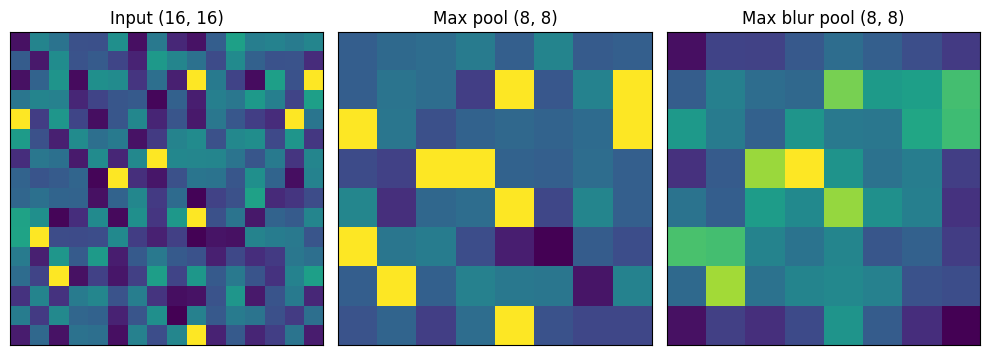

In [28]:
rng = np.random.default_rng(42)
max_pool_size = 2
input_arr = rng.integers(0, 150, size=(16, 16))

# draw N random 2D coordinates
N = 10
coords = rng.integers(0, 16, size=(N, 2))

# set those values to 255
input_arr[coords[:, 0], coords[:, 1]] = 255

# convert to tensor
input_tsr = Tensor(input_arr).unsqueeze(0).unsqueeze(0)

# apply max pool
max_pool = MaxPool2d(kernel_size=max_pool_size)
output_tsr_maxpool = max_pool(input_tsr)
output_arr_maxpool = output_tsr_maxpool.squeeze().numpy()

# apply max blur pool
max_blur_pool = MaxBlurPool(dim=2, kernel_size=3, max_pool_size=max_pool_size)
output_tsr_maxblurpool = max_blur_pool(input_tsr)
output_arr_maxblurpool = output_tsr_maxblurpool.squeeze().numpy()

# plot the results
fig, ax = plt.subplots(1, 3, figsize=(10, 15))
ax[0].imshow(input_arr)
ax[0].set_title(f"Input {input_arr.shape}")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(output_arr_maxpool)
ax[1].set_title(f"Max pool {output_arr_maxpool.shape}")
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(output_arr_maxblurpool)
ax[2].set_title(f"Max blur pool {output_arr_maxblurpool.shape}")
ax[2].set_xticks([])
ax[2].set_yticks([])
fig.tight_layout()


*Fig 3.: Max pool vs max blur pool downsampling. An input (left) is passed through a 
max pool layer (center) and through a max blur pool layer (right) for comparison. 
The blur pool layer introduces blurring, avoiding aliasing related artefacts. CC-BY.* 

### Changes to the masking scheme

In Noise2Void, the masking scheme consists in replacing central pixels by a randomly
chosen neighboring pixel (see [the example](../n2v/Noise2Void/#training-noise2void)). 
N2V2 changes the strategy for pixel selection by replacing the central pixel with the
median of the patch. This leads to a masking with a lower difference between masked
pixel and its surrounding, preventing aliasing artefacts arising from sharp transitions
between masked and unmasked pixels.

[]

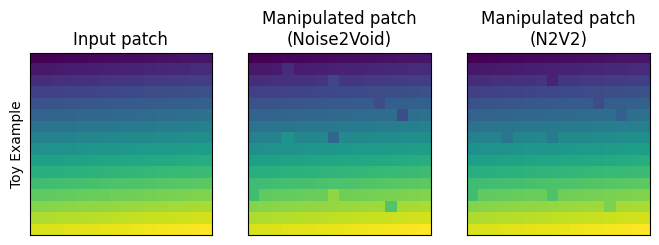

In [33]:
######### toy example
# array
scale = 16
patch = np.arange(scale**2).reshape((1, scale, scale))

# manipulate n2v
manipulate_uniform = N2VManipulate(roi_size=4, masked_pixel_percentage=2, seed=24)
manipulate_median = N2VManipulate(
    roi_size=4, masked_pixel_percentage=2, strategy="median", seed=24
)

# apply n2v manipulation
manipulated, _, mask = manipulate_uniform(patch)

# apply n2v manipulation with median
manipulated_median, _, mask_median = manipulate_median(patch)

# show manipulated patch next to mask
fig, ax = plt.subplots(1, 3, figsize=(8, 12))
ax[0].imshow(patch.squeeze())
ax[0].set_title("Input patch")
ax[0].set_ylabel("Toy Example")
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(manipulated.squeeze())
ax[1].set_title("Manipulated patch\n(Noise2Void)")
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(manipulated_median.squeeze())
ax[2].set_title("Manipulated patch\n(N2V2)")
ax[2].set_xticks([])
ax[2].set_yticks([])


*Fig 4.: Noise2Void vs N2V2 manipulation. In both algorithms, randomly selected pixels
in the input patch (left) are selected and their value replaced. Noise2Void (center) 
replaces the values by the value of one of the neighboring pixel, while N2V2 (right) 
uses the median of the neighborhood. CC-BY.* 


### Comparison

These changes allow suppressing the checkerboard artefacts, as illustrated in the figure below. 
N2V2 does not take longer than Noise2Void to train, and you can easily compare the results
of both methods.

<p align="center">
  <img src="https://raw.githubusercontent.com/CAREamics/careamics-examples/main/algorithms/n2v2/n2v_vs_n2v2_checkerboard.png" width="700"/>
</p>

*Fig 5.: Noise2Void vs N2V2 in the presence of checkerboard artefacts. The figure shows 
a noisy image crop (left), the Noise2Void prediction of the region delimited by a red 
square (center) and the corresponding N2V2 prediction (right). The cherckerboard artefacts
are clearly visible in the Noise2Void prediction (center), while they are much less 
severe with N2V2 (left). CC-BY.* 


To train Noise2Void and N2V2 on the same dataset, refer to their respective examples: 
[SEM Noise2Void](../../applications/Noise2Void/2D_SEM/) and [SEM N2V2](../../applications/Noise2Void/2D_SEM_N2V2/).

## Limitations

Beyond the checkerboard artefacts, N2V2 suffers from the same limitations as Noise2Void 
regarding [pixel-wise independent noise](../n2v/Noise2Void/#limitations).

## References

[1] Eva Höck, Tim-Oliver Buchholz, Anselm Brachmann, Florian Jug, and Alexander Freytag. "N2V2 - Fixing Noise2Void Checkerboard Artifacts with Modified Sampling Strategies and a Tweaked Network Architecture." ECCV, 2022. [link](https://link.springer.com/chapter/10.1007/978-3-031-25069-9_33)

[2] Alexander Krull, Tim-Oliver Buchholz, and Florian Jug. "Noise2Void - learning denoising
from single noisy images." CVPR, 2019. [link](https://openaccess.thecvf.com/content_CVPR_2019/html/Krull_Noise2Void_-_Learning_Denoising_From_Single_Noisy_Images_CVPR_2019_paper.html)

[3] Joshua Batson, and Loic Royer. "Noise2Self: Blind denoising by self-supervision." 
MLR, 2019. [link](http://proceedings.mlr.press/v97/batson19a.html)

[4] Olaf Ronneberger, Philipp Fischer, and Thomas Brox. "U-net: Convolutional networks for 
biomedical image segmentation." MICCAI, 2015. [link](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28)

[5] Richard Zhang. "Making convolutional networks shift-invariant again." ICML, 2019. [link](http://proceedings.mlr.press/v97/zhang19a.html)